In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from PIL import Image
from skimage.color import rgb2gray
from typing import Callable
from datetime import datetime
from helper_functions import *
from skimage.morphology import *

In [350]:
path = './data/train/2. noisy_bg/L1010335.JPG'

img_noisy = np.array(Image.open(path).resize((600,400)))

In [365]:
def remove_background(img):
    """
    Keep only silver, bronze, and golden pixels.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        New image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract RGB channels
    data_red, data_green, data_blue = extract_rgb_channels(img=img)
    
    # ------------------
    # Gold threshold
    min_r_gold = 170
    max_r_gold = 230
    min_g_gold = 120
    max_g_gold = 200
    min_b_gold = 40 # 20
    max_b_gold = 100 # 120
    
    # Bronze threshold
    min_r_bronze = 150
    max_r_bronze = 240
    min_g_bronze = 80
    max_g_bronze = 180
    min_b_bronze = 10
    max_b_bronze = 90
    
    # Silver threshold
    min_r_silver = 160
    max_r_silver = 200 # 200 # 240
    min_g_silver = 130
    max_g_silver = 210
    min_b_silver = 100 # DONT CHANGE
    max_b_silver = 150 # 150 # 170 # 190
    
    # Create masks for silver, bronze, and gold pixels
    silver_mask = ((data_red >= min_r_silver) & (data_red <= max_r_silver) &
                   (data_green >= min_g_silver) & (data_green <= max_g_silver) &
                   (data_blue >= min_b_silver) & (data_blue <= max_b_silver))
    
    bronze_mask = ((data_red >= min_r_bronze) & (data_red <= max_r_bronze) &
                   (data_green >= min_g_bronze) & (data_green <= max_g_bronze) &
                   (data_blue >= min_b_bronze) & (data_blue <= max_b_bronze))
    
    gold_mask = ((data_red >= min_r_gold) & (data_red <= max_r_gold) &
                 (data_green >= min_g_gold) & (data_green <= max_g_gold) &
                 (data_blue >= min_b_gold) & (data_blue <= max_b_gold))
    
    # Combine masks to keep only silver, bronze, and gold pixels
    final_mask = silver_mask | bronze_mask | gold_mask
    
    # Apply the mask to the image
    #img_th[final_mask] = 1
    img_th = img.copy()
    img_th[~final_mask] = [0, 0, 0]
    # ------------------

    return img_th


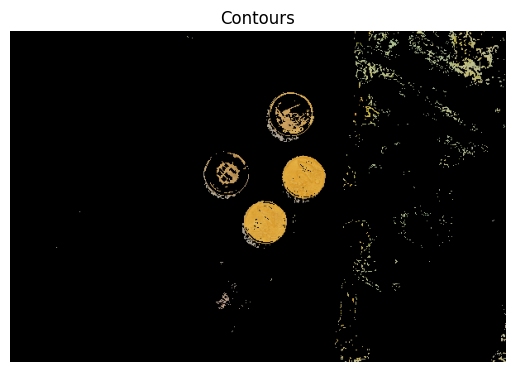

In [366]:
# noisy_nobg = remove_background(cv2.GaussianBlur(img_noisy, (7,7), 4))
noisy_nobg = remove_background(img_noisy)

plt.imshow(noisy_nobg)
plt.title('Contours')
plt.axis('off')
plt.show()

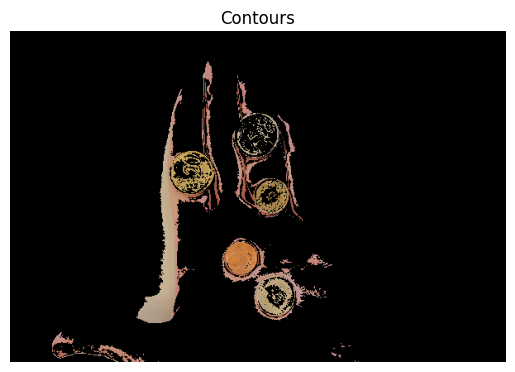

In [367]:
path_hand = './data/train/3. hand/L1010383.JPG'
img_hand = np.array(Image.open(path_hand).resize((600,400)))
#hand_nobg = remove_background(cv2.GaussianBlur(img_hand, (7,7), 2))
hand_nobg = remove_background(img_hand)
plt.imshow(hand_nobg)
plt.title('Contours')
plt.axis('off')
plt.show()

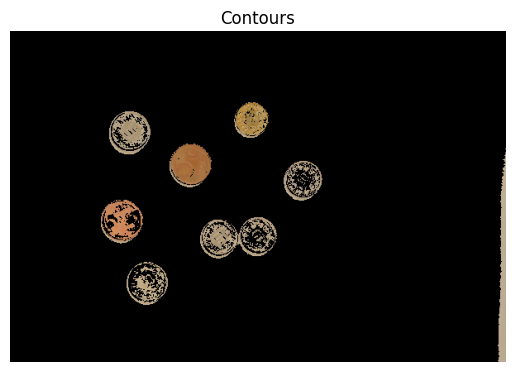

In [368]:
path_neutral = './data/train/1. neutral_bg/L1010281.JPG'
img_neutral = np.array(Image.open(path_neutral).resize((600,400)))
#neutral_nobg = remove_background(cv2.GaussianBlur(img_neutral, (7,7), 2))
neutral_nobg = remove_background(img_neutral)
plt.imshow(neutral_nobg)
plt.title('Contours')
plt.axis('off')
plt.show()

In [391]:
import cv2
import numpy as np

def find_round_contours(image, min_radius=10, max_radius=50):
    # Apply Gaussian blur to reduce noise (if needed)
    blurred = cv2.GaussianBlur(image, (5, 5), 0.8)

    # Apply Hough Circle Transform
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=50, param1=100, param2=30, minRadius=min_radius, maxRadius=max_radius)

    return circles


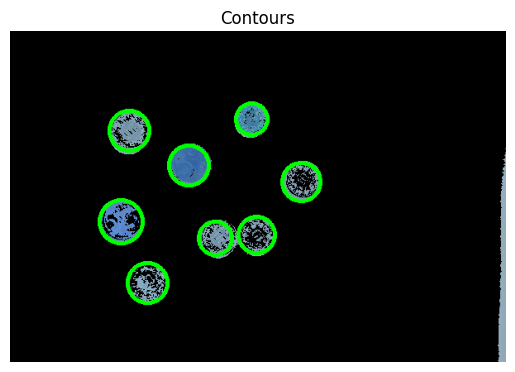

In [394]:
image = neutral_nobg

# Convert the image to grayscale
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Apply thresholding to convert the grayscale image to binary
_, binary_image = cv2.threshold(image_gray, 127, 255, cv2.THRESH_BINARY)

# Perform morphological opening to remove noise
#kernel_open = np.ones((1, 1), np.uint8)
#opening = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel_open, iterations=4)
#remove = remove_small_objects(opening, 12400)
# Find round contours in the binary image
circles = find_round_contours(binary_image)

# Draw circles on a copy of the original image
image_with_circles = image.copy()
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(image_with_circles, (x, y), r, (0, 255, 0), 4)

# Display the image with detected circles
plt.imshow(cv2.cvtColor(image_with_circles, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title('Contours')
plt.axis('off')
plt.show()

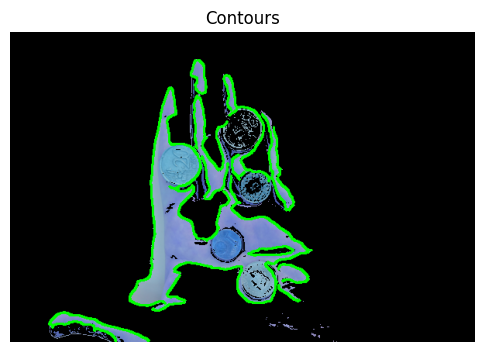

In [361]:
img = hand_nobg

# Convert to grayscale
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(grey, (17, 17), 0)
'''
# Display original, grayscale, and blurred images as subplots
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(grey, cmap='gray')
plt.title('Grey Scale')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(blurred, cmap='gray')
plt.title('Blurred')
plt.axis('off')

plt.show()
'''
# Canny edge detector
outline = cv2.Canny(blurred, 30, 150)
(cnts, _) = cv2.findContours(outline, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
'''
plt.figure(figsize=(6, 6))
plt.imshow(outline, cmap='gray')
plt.title('Canny Edge Detector')
plt.axis('off')
plt.show()
'''


# Find contours
(cnts, _) = cv2.findContours(outline, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
result = img.copy()
cv2.drawContours(result, cnts, -1, (0, 255, 0), 2)

# Display the result
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Contours')
plt.axis('off')
plt.show()

In [362]:
def project_detect_and_annotate_circles(original_img, processed_img, scale_percent, param1=30, show = False):
    """
    Detects circles in a processed image, scales the detections back to the original image size,
    annotates them, and displays the annotated image.

    Args:
        original_img (np.ndarray): The original image.
        processed_img (np.ndarray): Pre-processed image for circle detection (e.g., thresholded).
        scale_percent (int): The percentage scale used when resizing the original image.
        param1 (int): Parameter for the internal Canny edge detector in HoughCircles.

    Displays:
        The resized original image with annotated detections.

    Returns:
        Detected circles
    """
    original_height, original_width = original_img.shape[:2]
    new_width = int(original_width * scale_percent / 100)
    new_height = int(original_height * scale_percent / 100)

    # Calculate scale factors
    scale_x = original_width / new_width
    scale_y = original_height / new_height

    # Detect circles in the processed image
    detected_circles = cv2.HoughCircles(processed_img, cv2.HOUGH_GRADIENT, dp=1, minDist=30,
                                        param1=param1, param2=int(param1/2), minRadius=17, maxRadius=45)

    if detected_circles is not None:
        detected_circles = np.uint16(np.around(detected_circles))

        print(f"Number of circles detected: {len(detected_circles[0])}")
        for i, (x_resized, y_resized, r_resized) in enumerate(detected_circles[0, :]):
            x_original = int(x_resized * scale_x)
            y_original = int(y_resized * scale_y)
            r_original = int(r_resized * scale_x)  # assuming uniform scaling
            print(f"Circle {i+1}: Center at ({x_original}, {y_original}), Radius: {r_original}")

        # Visualize results on the resized image
        img_annotated = original_img.copy()
        img_annotated = cv2.resize(img_annotated, (new_width, new_height))
        for i, (x, y, r) in enumerate(detected_circles[0, :]):
            cv2.circle(img_annotated, (x, y), r, (0, 255, 0), 2)
            cv2.circle(img_annotated, (x, y), 1, (0, 0, 255), 3)
            label = f"C{i+1}-r:{int(r*scale_x)}"
            cv2.putText(img_annotated, label, (x - 50, y - r - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (255, 0, 0), 1, cv2.LINE_AA)

        if show:
            plt.imshow(cv2.cvtColor(img_annotated, cv2.COLOR_BGR2RGB))
            plt.axis('on')
            plt.grid(False)
            plt.show()
        
        return detected_circles
    else:
        print("No circles detected.")
        return 0

In [192]:
path_neutral = './data/train/1. neutral_bg/L1010281.JPG'
img_neutral = np.array(path_neutral)
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(project_detect_and_annotate_circles(neutral_nobg, img_neutral, 0.1), cv2.COLOR_BGR2RGB))
plt.title('Contours')
plt.axis('off')
plt.show()

ZeroDivisionError: division by zero

<Figure size 600x600 with 0 Axes>

In [ ]:
path_neutral = './data/train/1. neutral_bg/L1010281.JPG'
img_og = np.array(Image.open(path_neutral))
img_neutral = np.array(Image.open(path_neutral).resize((600,400)))
neutral_nobg = remove_background(img_neutral)
project_detect_and_annotate_circles(img_og, neutral_nobg, 0.1, param1=30, show = True)



## TRYING THRESHOLD WITH SHU METHOD

In [379]:
def project_apply_hsv_threshold(img, hs_limits):
    """
    Apply threshold to the input image in HSV color space.

    Args:
        img (np.ndarray): Input image of shape (M, N, 3) with RGB color space.
        hsv_limits (tuple): Tuple of tuples defining the min and max HSV thresholds:
                            ((h_min, h_max), (s_min, s_max), (v_min, v_max))

    Returns:
        np.ndarray: Thresholded binary image to 0 or 255.
    """
    # Extract HSV channels
    h, s, _ = extract_hsv_channels(img)
    
    # Apply thresholds for each channel
    h_min, h_max = hs_limits[0]
    s_min, s_max = hs_limits[1]
    # v_min, v_max = hs_limits[2]

    h_th = (h > h_min) & (h < h_max)
    s_th = (s > s_min) & (s < s_max)
    # v_th = (v > v_min) & (v < v_max)

    # Reconstruct image by combining the thresholded channels
    img_th = np.logical_and(h_th, s_th)

    img_th_uint8 = np.uint8(img_th * 255)  # Convert boolean to 0 or 255

    return img_th_uint8

In [382]:
hsv_limits = ((0.058, 0.13),(0.1, 0.85))
img_th = project_apply_hsv_threshold(img_noisy, hsv_limits)

In [383]:
img_circle = find_round_contours(img_th)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


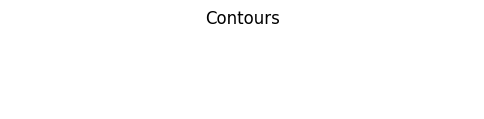

In [387]:
plt.figure(figsize=(6, 6))
plt.imshow(img_circle)
plt.title('Contours')
plt.axis('off')
plt.show()

# CLEAN

## CLEAN FCT TO REMOVE BG

In [409]:
def remove_background(img):
    """
    Keep only silver, bronze, and golden pixels.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        New image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract RGB channels
    data_red, data_green, data_blue = extract_rgb_channels(img=img)
    
    # ------------------
    # Gold threshold
    min_r_gold = 170
    max_r_gold = 230
    min_g_gold = 120
    max_g_gold = 200
    min_b_gold = 40 # 20
    max_b_gold = 100 # 120
    
    # Bronze threshold
    min_r_bronze = 150
    max_r_bronze = 240
    min_g_bronze = 80
    max_g_bronze = 180
    min_b_bronze = 10
    max_b_bronze = 90
    
    # Silver threshold
    min_r_silver = 160
    max_r_silver = 200 # 200 # 240
    min_g_silver = 130
    max_g_silver = 210
    min_b_silver = 100 # DONT CHANGE
    max_b_silver = 150 # 150 # 170 # 190
    
    # Create masks for silver, bronze, and gold pixels
    silver_mask = ((data_red >= min_r_silver) & (data_red <= max_r_silver) &
                   (data_green >= min_g_silver) & (data_green <= max_g_silver) &
                   (data_blue >= min_b_silver) & (data_blue <= max_b_silver))
    
    bronze_mask = ((data_red >= min_r_bronze) & (data_red <= max_r_bronze) &
                   (data_green >= min_g_bronze) & (data_green <= max_g_bronze) &
                   (data_blue >= min_b_bronze) & (data_blue <= max_b_bronze))
    
    gold_mask = ((data_red >= min_r_gold) & (data_red <= max_r_gold) &
                 (data_green >= min_g_gold) & (data_green <= max_g_gold) &
                 (data_blue >= min_b_gold) & (data_blue <= max_b_gold))
    
    # Combine masks to keep only silver, bronze, and gold pixels
    final_mask = silver_mask | bronze_mask | gold_mask
    
    # Apply the mask to the image
    #img_th[final_mask] = 1
    img_th = img.copy()
    img_th[~final_mask] = [0, 0, 0]
    # ------------------

    return img_th


## CLEAN FUNCTION TO DETECT CIRCLES

In [396]:
import cv2
import numpy as np

def find_round_contours(image, min_radius=10, max_radius=50):
    # Apply Gaussian blur to reduce noise (if needed)
    blurred = cv2.GaussianBlur(image, (5, 5), 0.8)

    # Apply Hough Circle Transform
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=50, param1=100, param2=30, minRadius=min_radius, maxRadius=max_radius)

    return circles


In [410]:
def find_contours(image):

    image = remove_background(image)
    # Convert the image to grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply thresholding to convert the grayscale image to binary
    _, binary_image = cv2.threshold(image_gray, 127, 255, cv2.THRESH_BINARY)

    # Find round contours in the binary image
    circles = find_round_contours(binary_image)

    # Draw circles on a copy of the original image
    image_with_circles = image.copy()
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            cv2.circle(image_with_circles, (x, y), r, (0, 255, 0), 4)

    # Display the image with detected circles
    plt.imshow(cv2.cvtColor(image_with_circles, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title('Contours')
    plt.axis('off')
    plt.show()

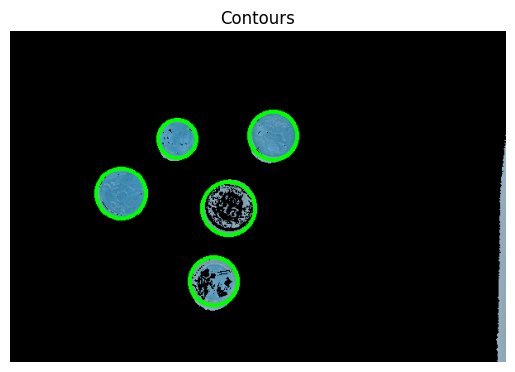

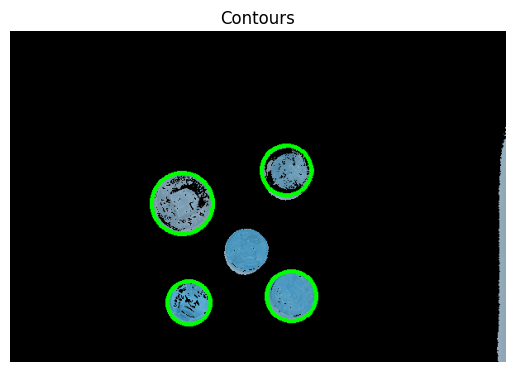

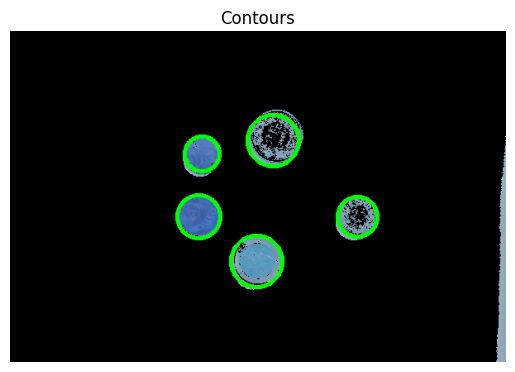

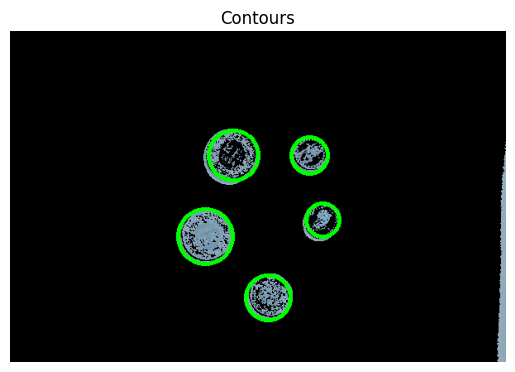

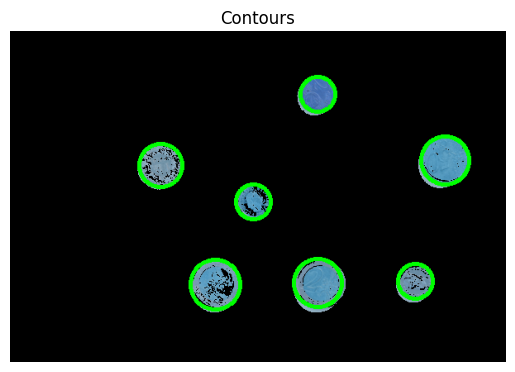

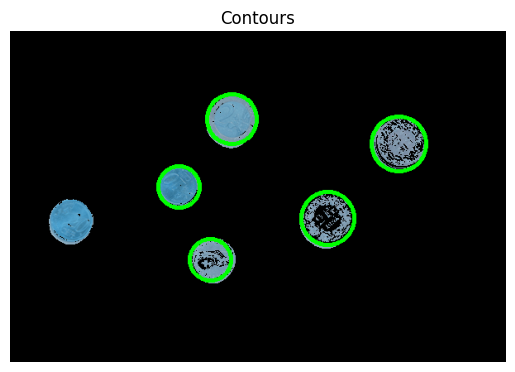

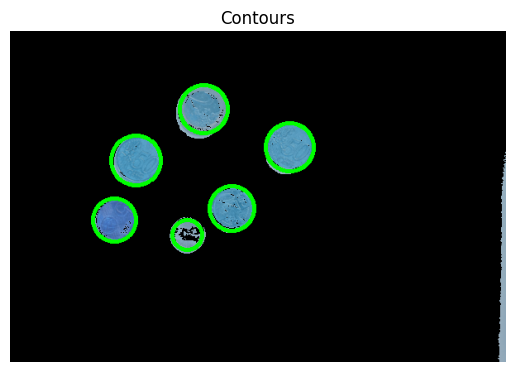

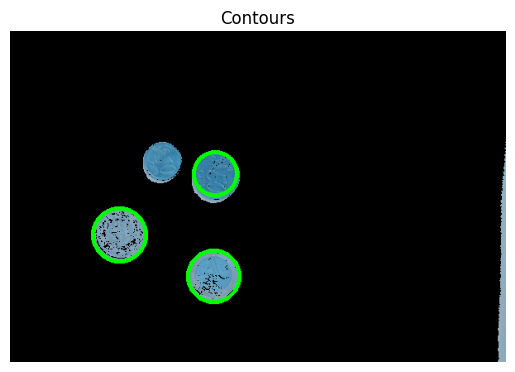

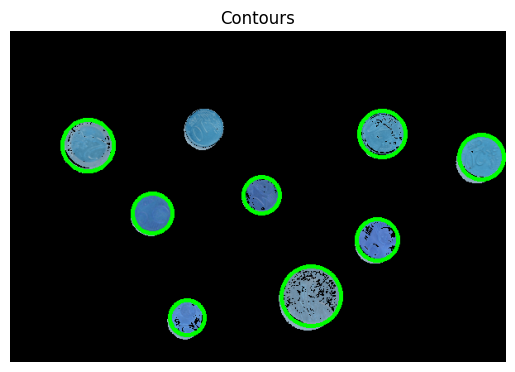

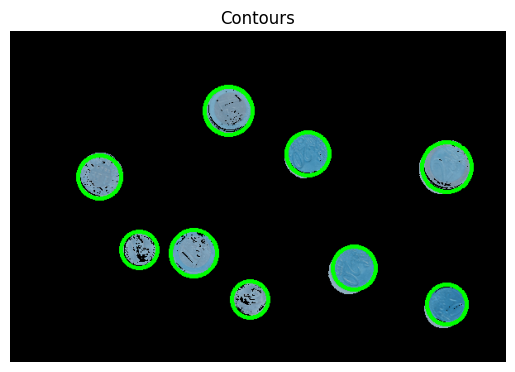

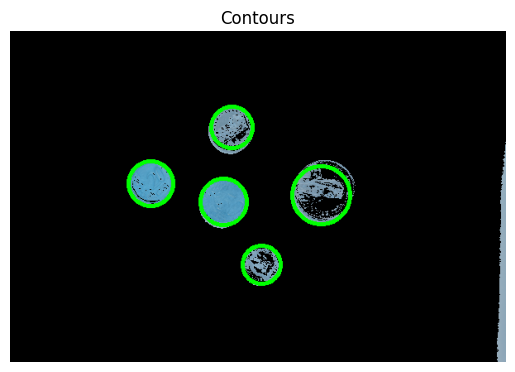

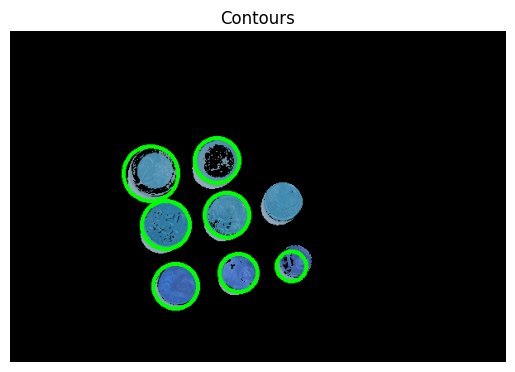

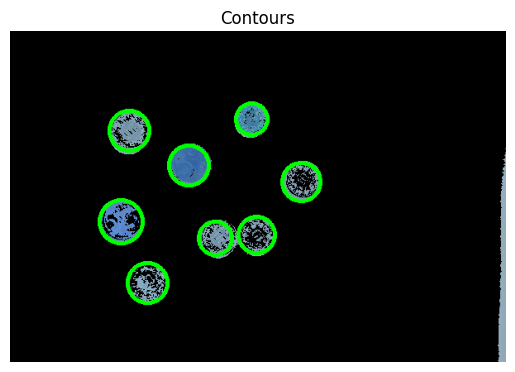

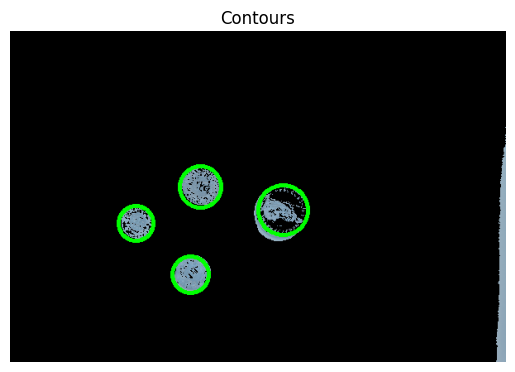

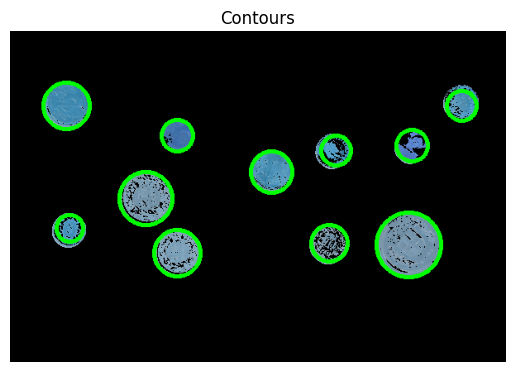

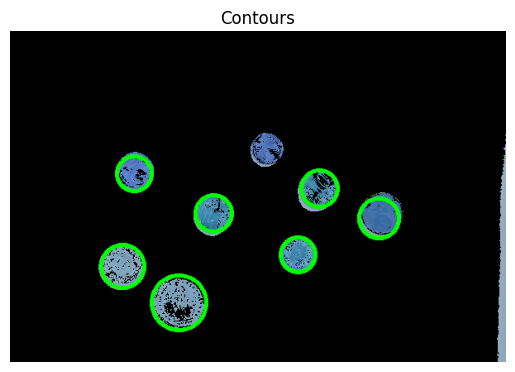

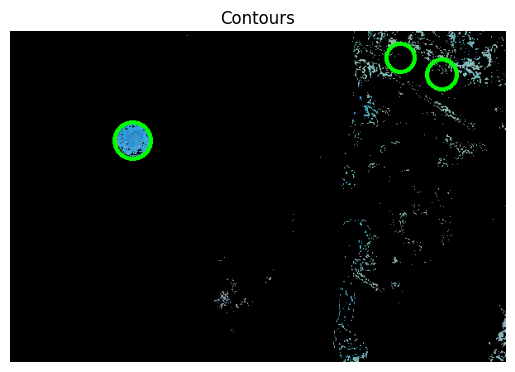

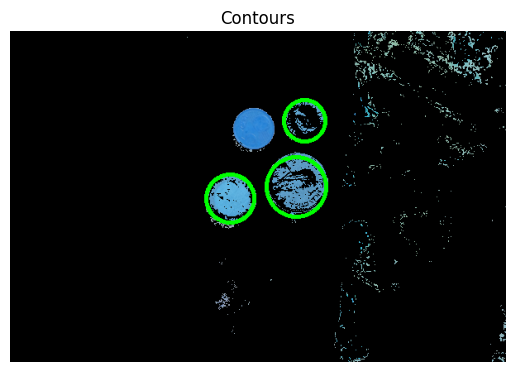

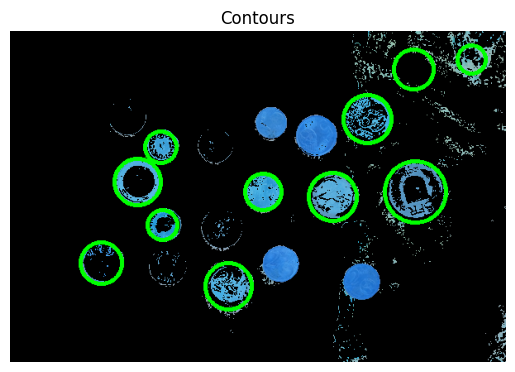

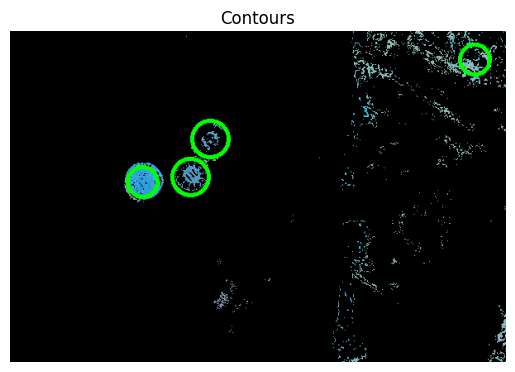

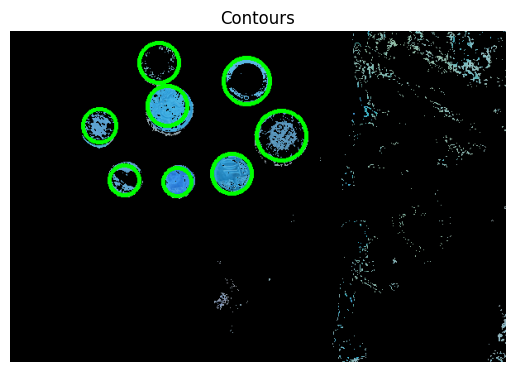

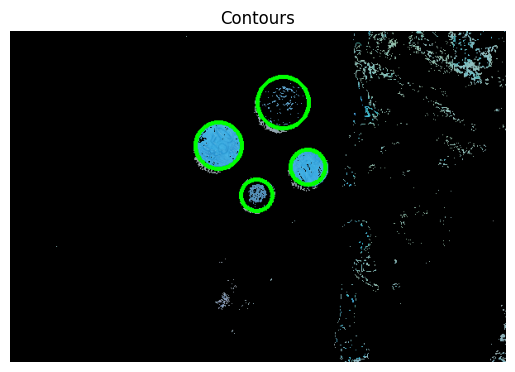

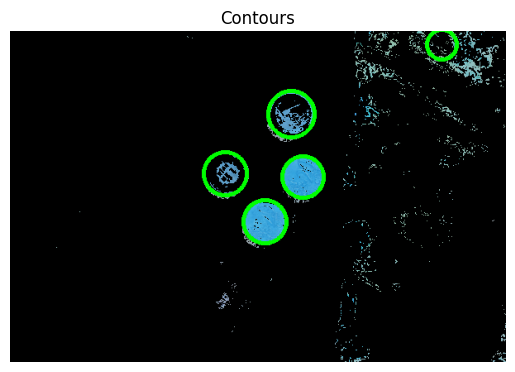

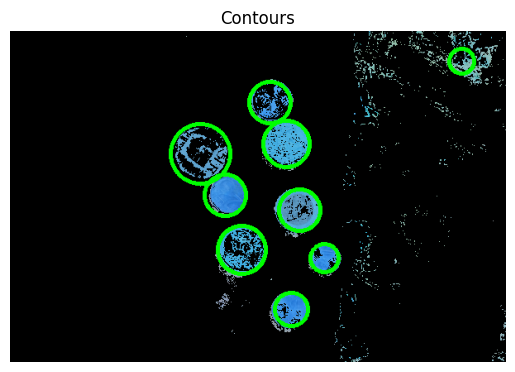

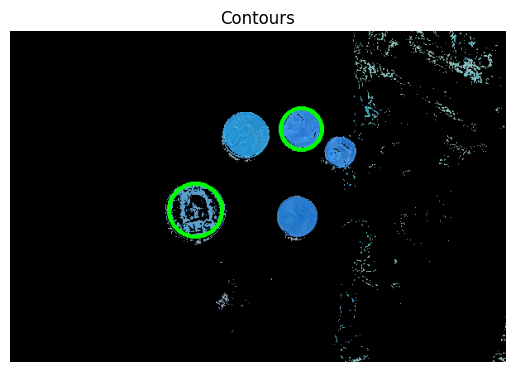

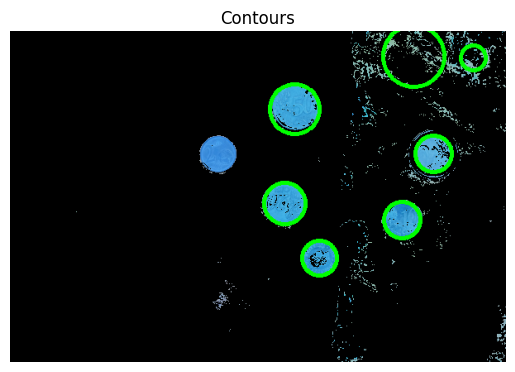

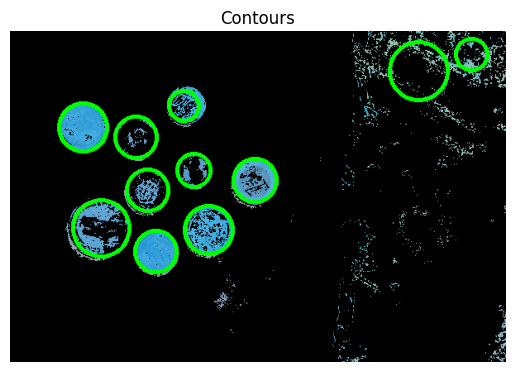

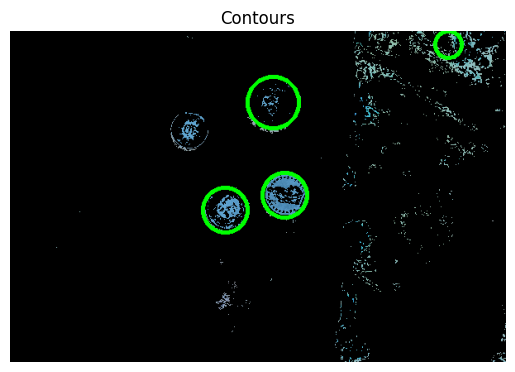

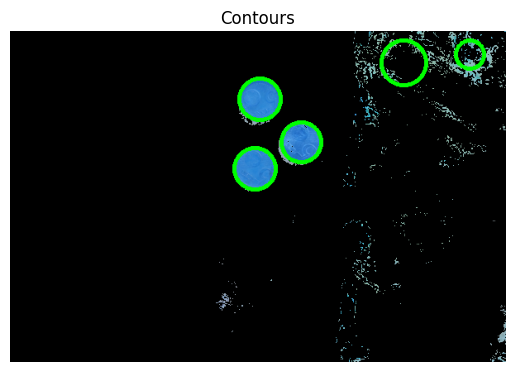

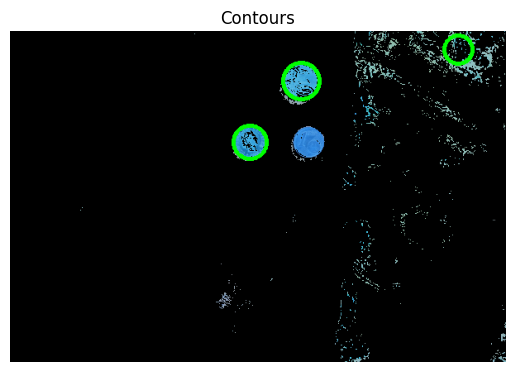

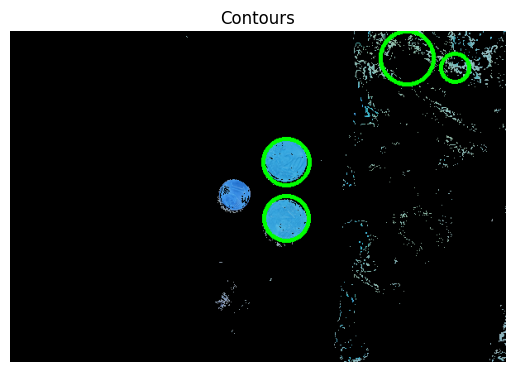

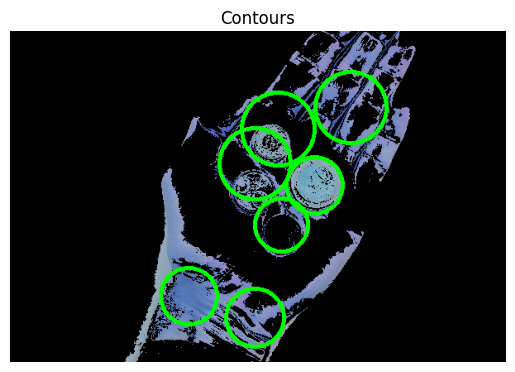

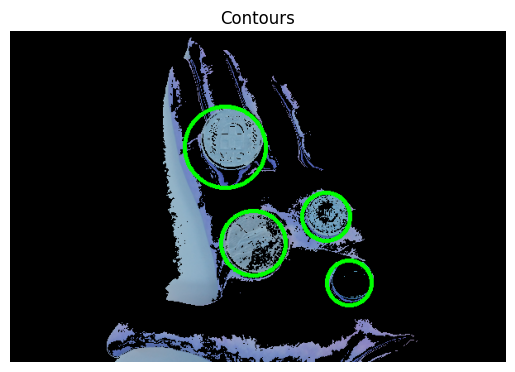

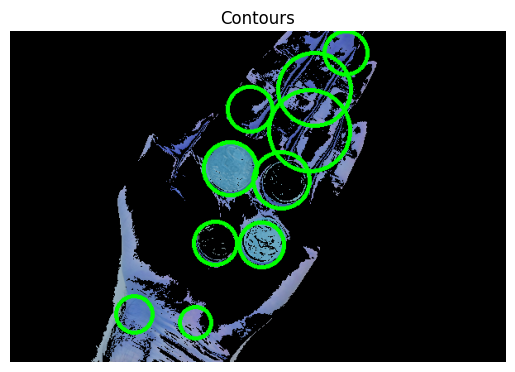

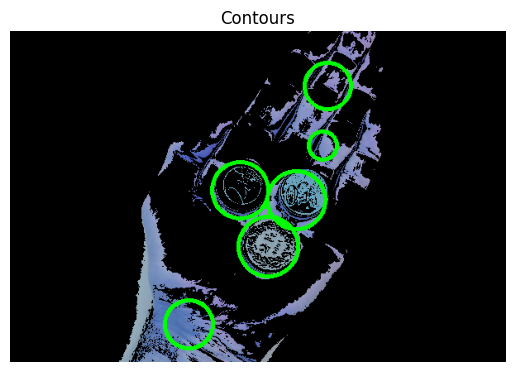

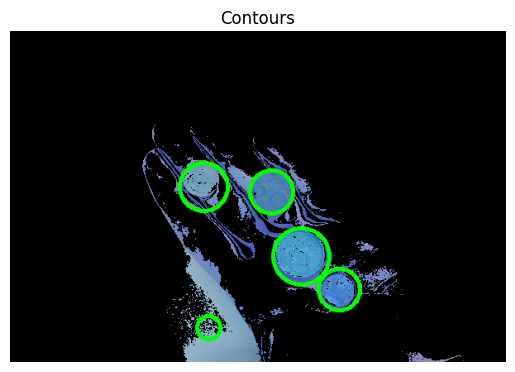

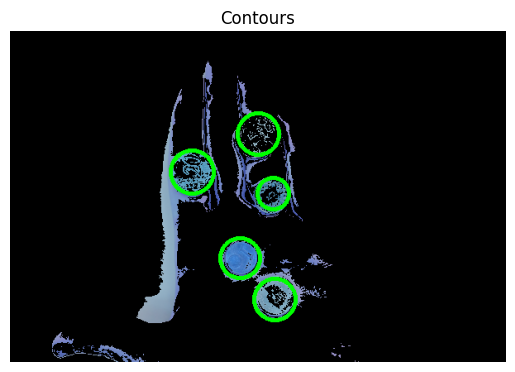

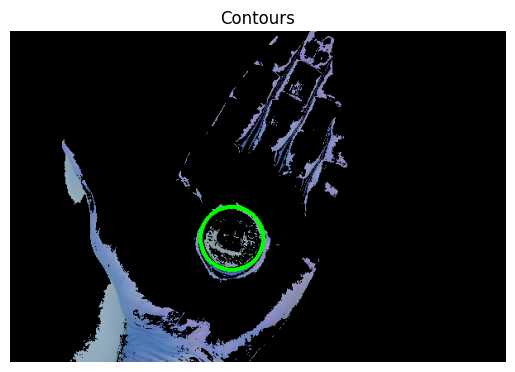

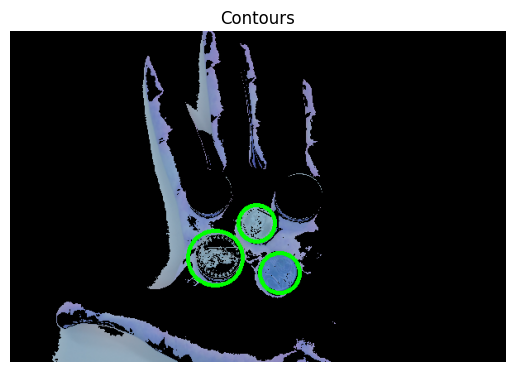

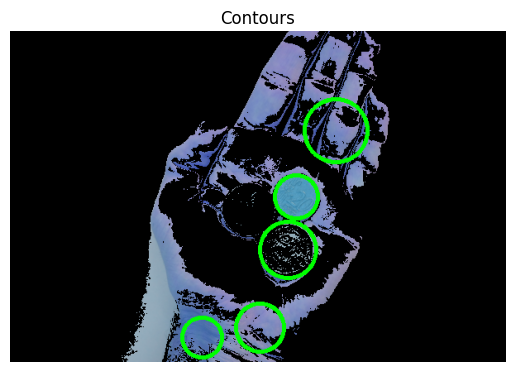

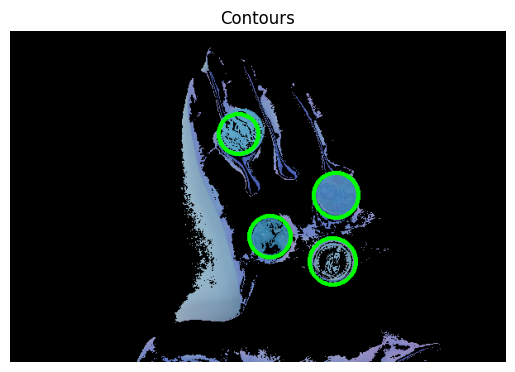

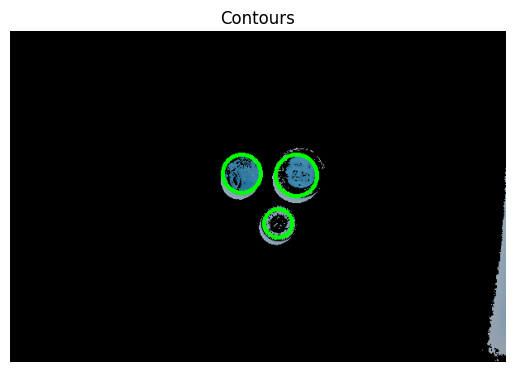

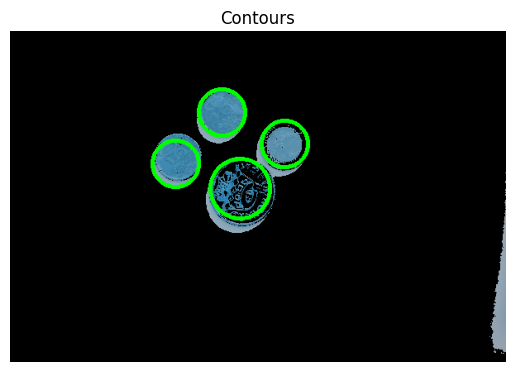

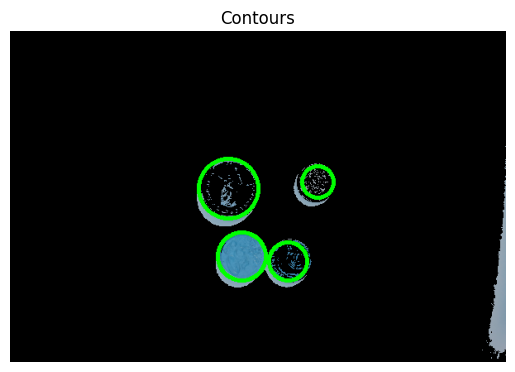

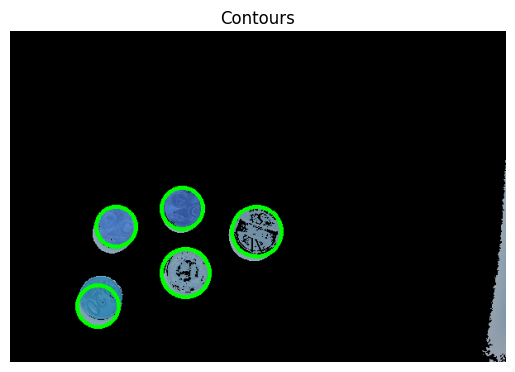

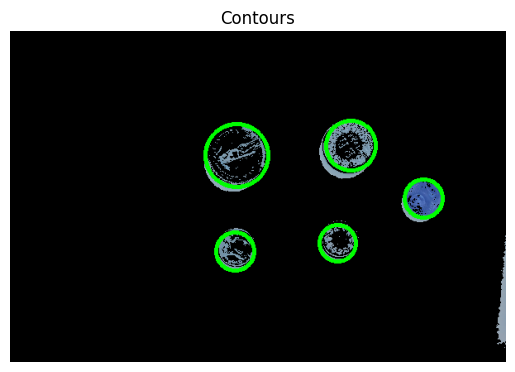

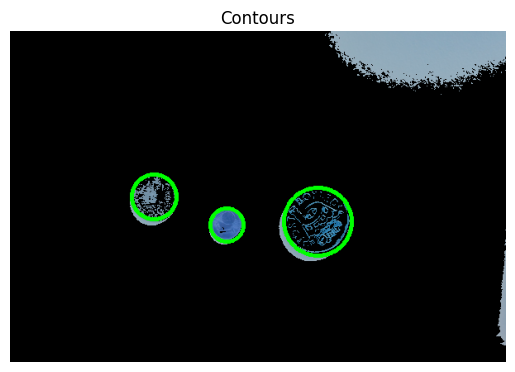

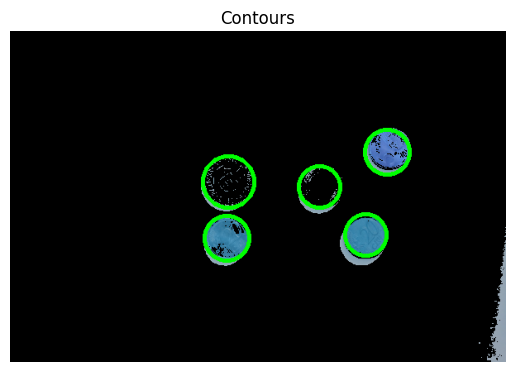

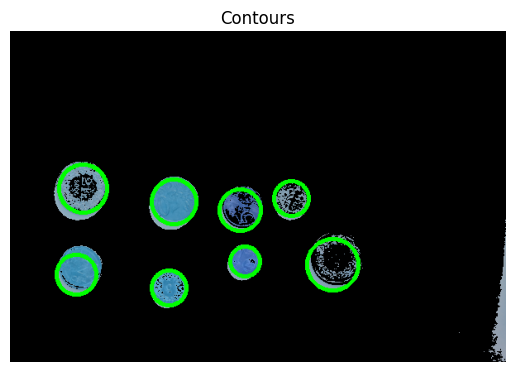

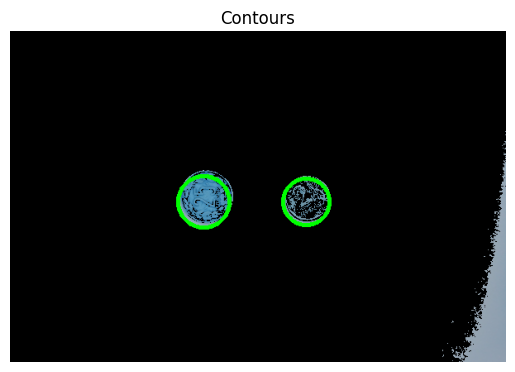

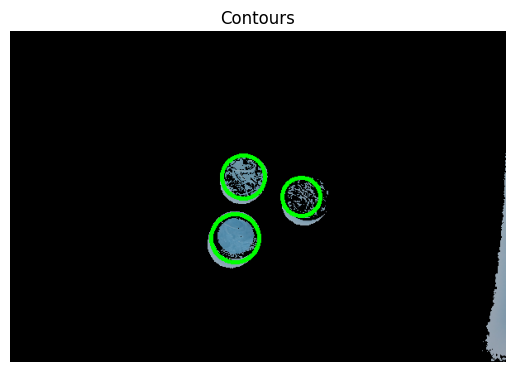

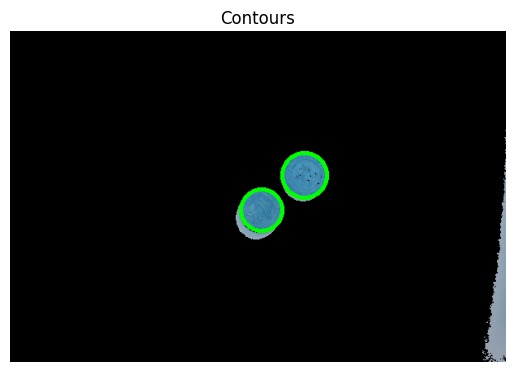

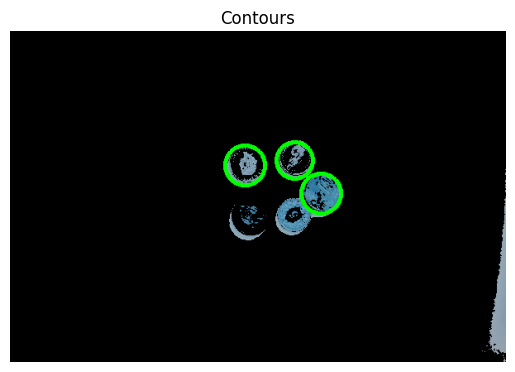

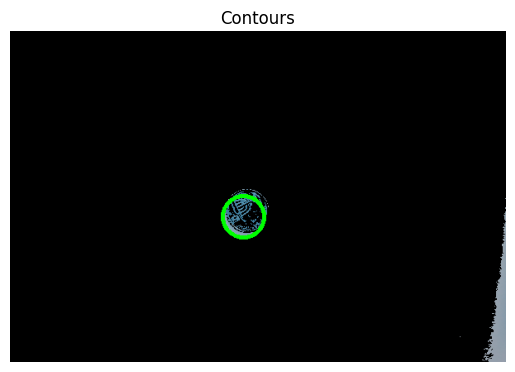

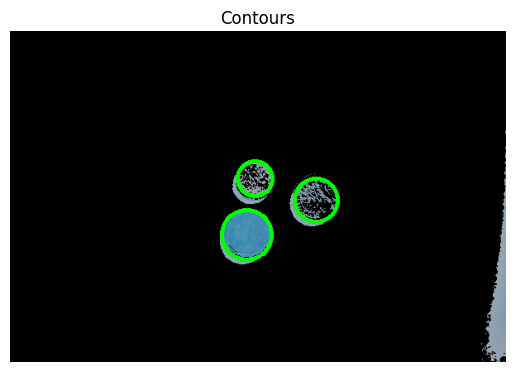

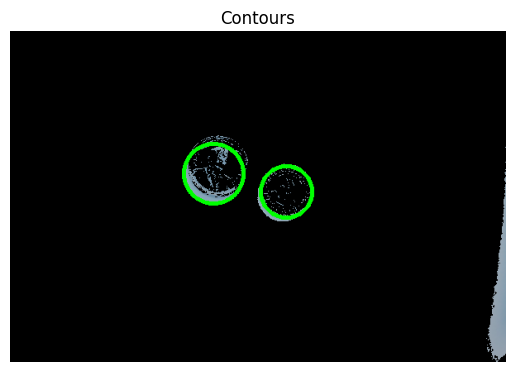

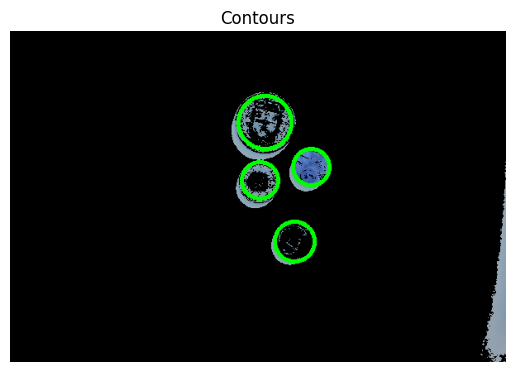

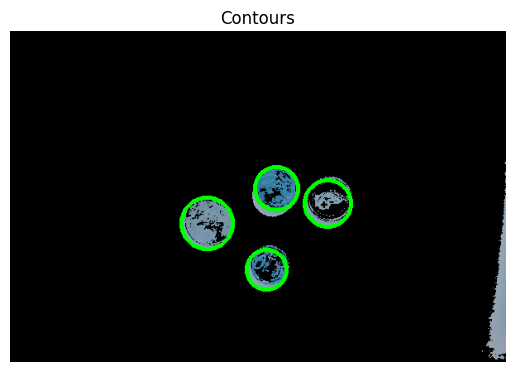

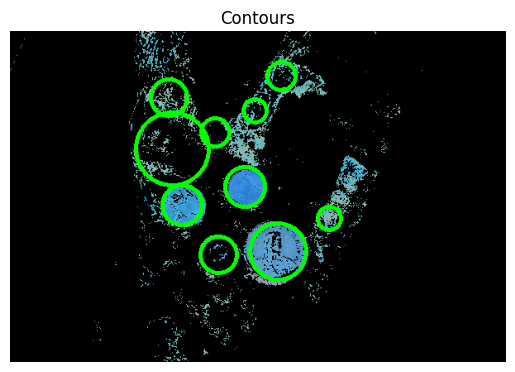

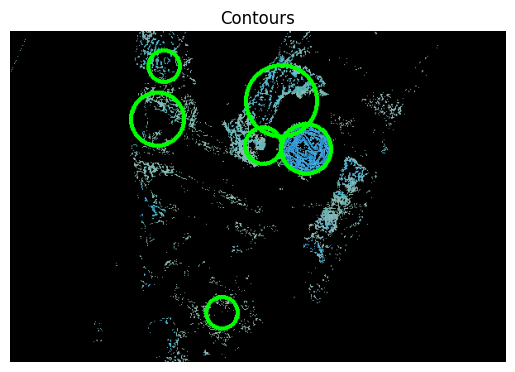

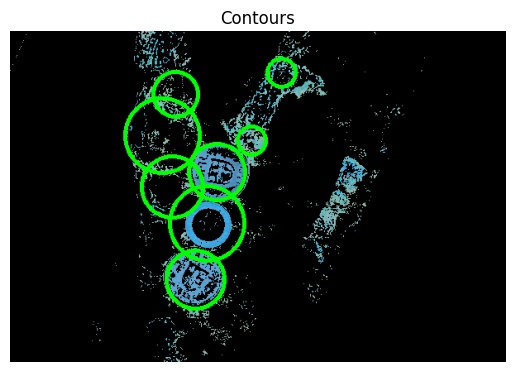

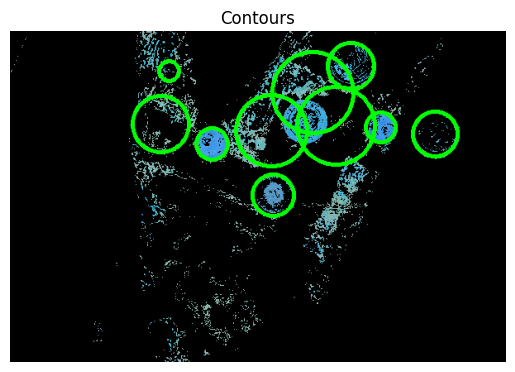

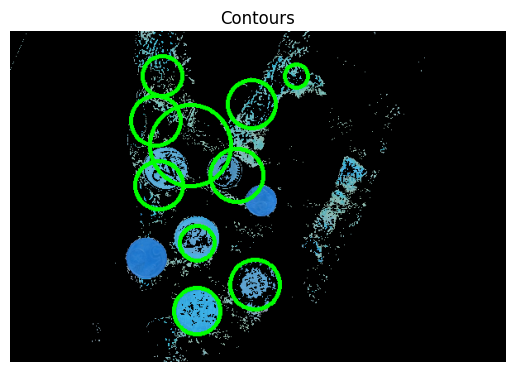

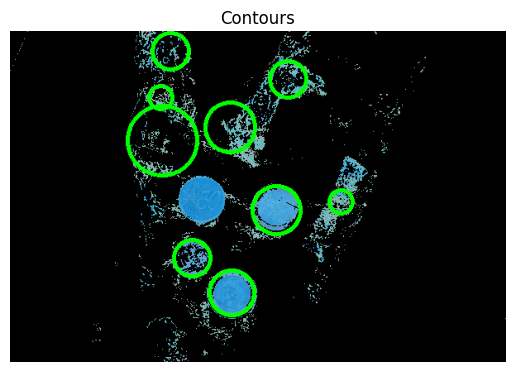

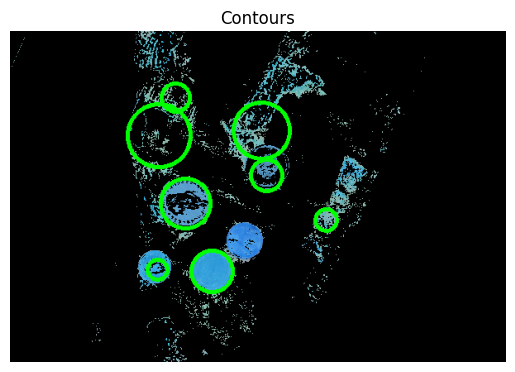

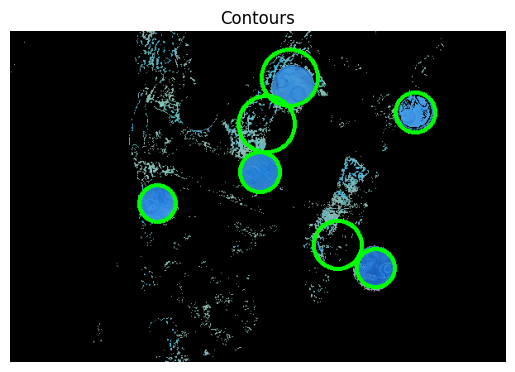

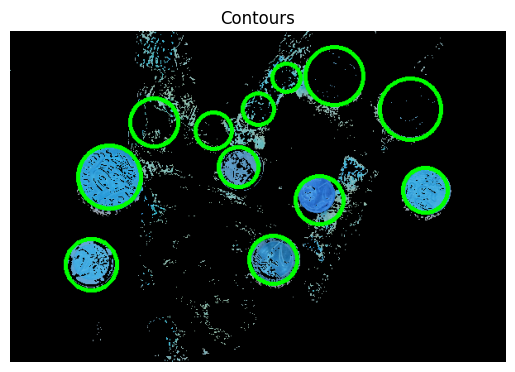

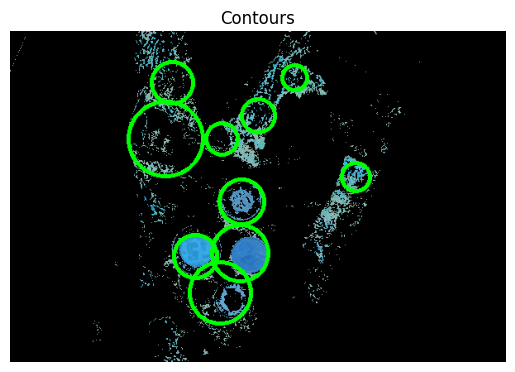

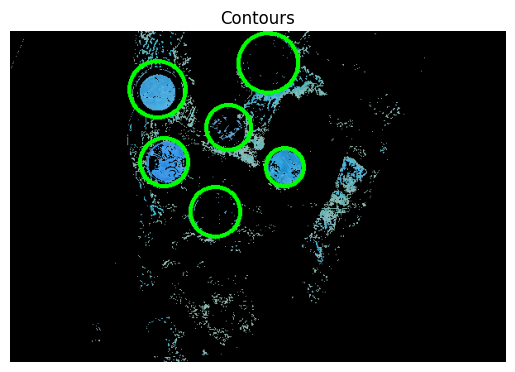

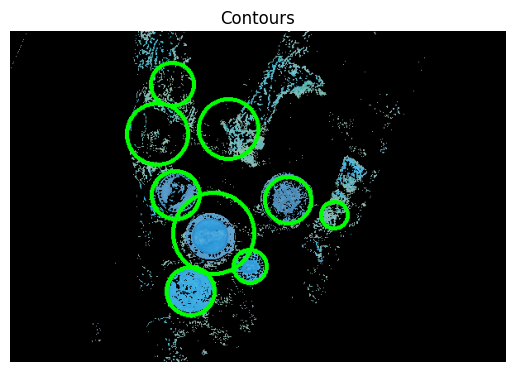

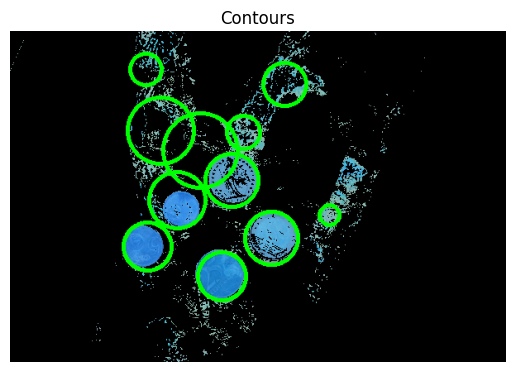

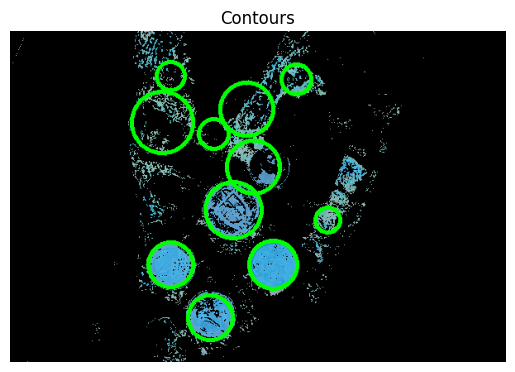

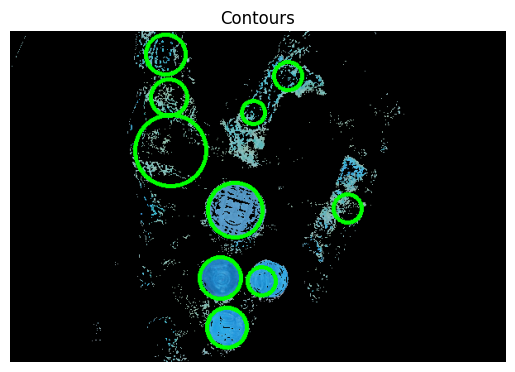

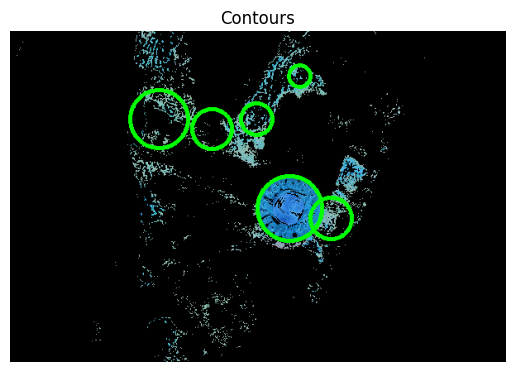

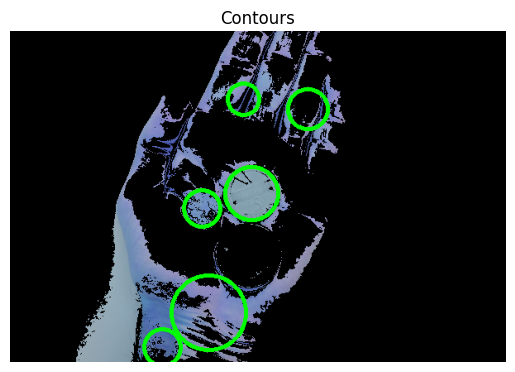

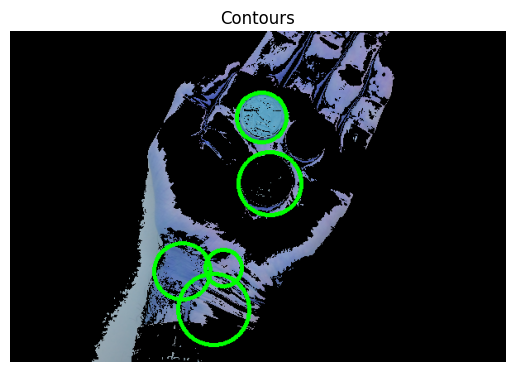

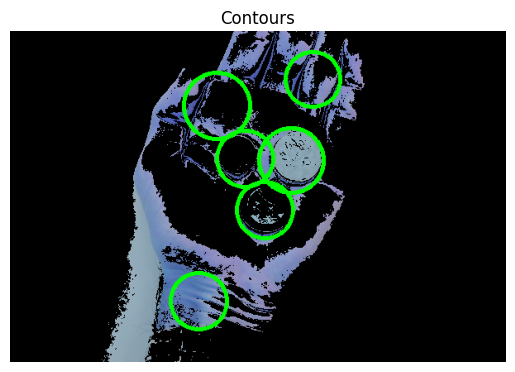

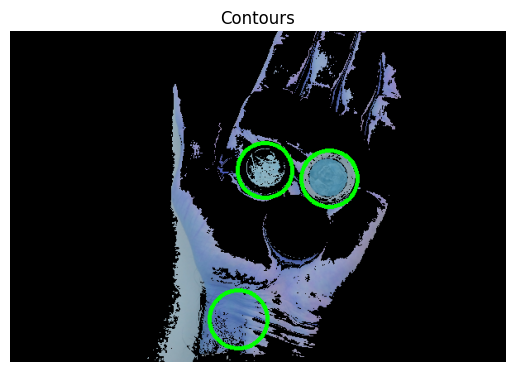

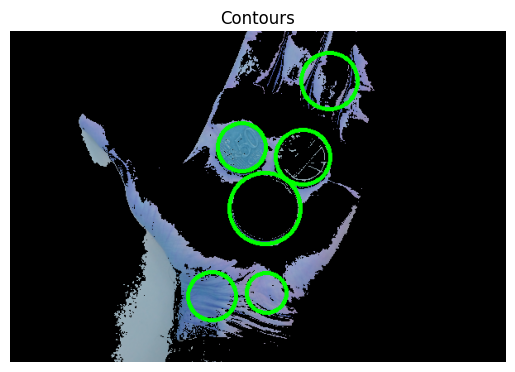

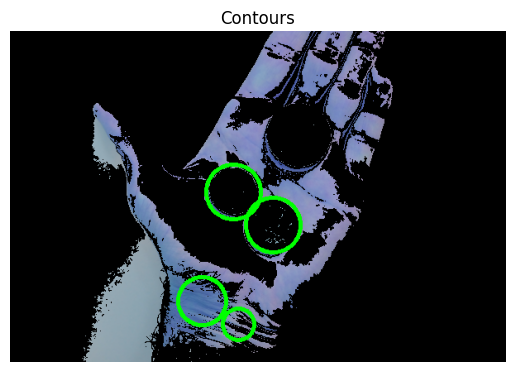

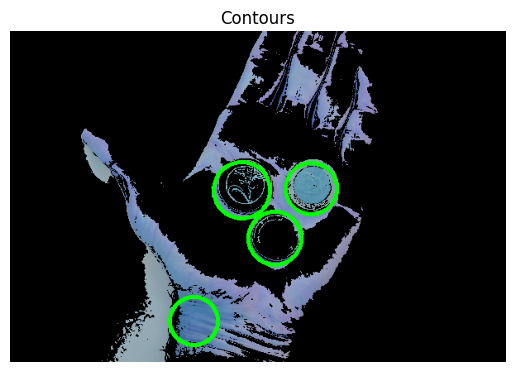

In [411]:
folders = ['1. neutral_bg', '2. noisy_bg', '3. hand', '4. neutral_bg_outliers', '5. noisy_bg_outliers', '6. hand_outliers']

# Create an empty list to store image data
image_data = []

path = "data/train"
# Iterate through each folder
for folder in folders:
    # Get the path to the folder
    folder_path = os.path.join(path, folder)

    # Iterate through each image in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is an image (e.g., ends with '.jpg', '.png', etc.)
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Get the full path to the image
            image_path = os.path.join(folder_path, filename)

            # Load the image using PIL
            original_image = np.array(Image.open(image_path).resize((600,400)))

            find_contours(original_image)